# Minimum Time Maneuver for a Crane

In [ ]:
# Imports
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

## Given

In [ ]:
m = 0.1  # Mass
theta = (np.pi / 180) * 15  # Theta (in radians)
Tmax = 2  # Max tension
h = 0.1  # Time Step
p_init = np.array([0, 0])  # 1*2
p_des = np.array([10, 2])  # 1*2
g = np.array([0, -9.8])  # 1*2

left_mul = np.array([-np.sin(theta), np.cos(theta)])
right_mul = np.array([np.sin(theta), np.cos(theta)])

## Function for checking

This is a function to check if the value of k provides us with an optimal solution

Returns True or False

In [ ]:
def trySolve(k: int, return_data: bool=False) -> bool:

    # Special case when k = 1
    if (k == 1):
        return np.all(p_init == p_des)

    Tl = cp.Variable(k-1)  # Tension in the left wire
    Tr = cp.Variable(k-1)  # Tension in the right wire
    p = cp.Variable((k, 2))  # Positions
    v = cp.Variable((k, 2))  # Velocities

    constraints = [
                   p[0] == p_init,  # Initially starts at p_init
                   p[k-1] == p_des,  # Finally ends at p_des

                   v[0] == np.zeros(2),  # Initially, velocity is 0
                   v[k-1] == np.zeros(2),  # Finally, velocity is 0

                   Tl <= Tmax,  # Max Condition
                   Tr <= Tmax,  # Max Condition
                   Tl >= 0,  # Tension can't be negative
                   Tr >= 0,  # Tension can't be negative
    ]

    # Appending the constraints of motion
    for i in range(k-1):
        force = Tl[i]*left_mul + Tr[i]*right_mul + m*g
        constraints += [
                        v[i+1] == force*h/m + v[i],
                        p[i+1] == v[i]*h + p[i]
        ]
    
    prob = cp.Problem(cp.Minimize(0), constraints)  # Only Constraints
    prob.solve()

    if (not return_data):
        return prob.status == 'optimal'
    return (Tl.value, Tr.value, p.value, v.value)


## Bisection Method 

In [ ]:
# Implementing the Bisection Method

def bisectionAnswer() -> int:

    # Special Case when the problem is already solved
    if (trySolve(1)):
        return 1

    # Finding the upper bound and the lower bound (Takes O(log k))
    upper = 2
    while (not trySolve(upper)):
        upper *= 2
    lower = upper/2 + 1  # Since it failed for upper/2

    # We know that lower <= k_optimal <= upper
    # We iterate till lower = upper implying lower = k_optimal = upper
    # Terminates when lower = upper
    while (lower < upper):
        k = int((upper + lower) / 2)
        if (trySolve(k)):
            # This means it is valid for k implying k_optimal <= k
            upper = k
        else:
            # Fails implying k_optimal > k
            lower = k+1
    
    # upper = lower = k_optimal 
    return upper

k_optimal = bisectionAnswer()
print("The Optimal Value of k:", k_optimal)

The Optimal Value of k: 34


## Graphing

In [ ]:
Tl, Tr, p, v = trySolve(k_optimal, return_data=True)

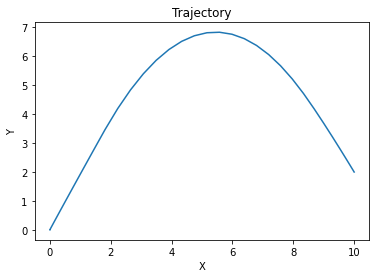

In [ ]:
# Trajectory
plt.plot(p.T[0], p.T[1])
plt.title("Trajectory")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

print()

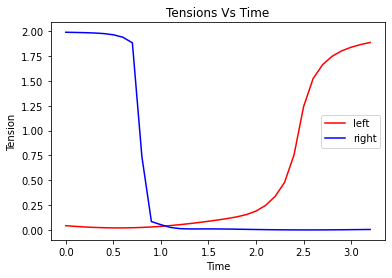

In [ ]:
times = np.array([i*h for i in range(k_optimal-1)])

plt.plot(times, Tl, c='r', label="left")
plt.plot(times, Tr, c='b', label="right")
plt.title("Tensions Vs Time")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Tension")
plt.show()

print()